In [1]:
# Run once only for flake8
%load_ext pycodestyle_magic
%pycodestyle_on or %flake8_on

In [61]:
import os
import numpy as np
import scipy.stats
import torch
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings
import pyro
import pyro.distributions as dist

from collections import defaultdict
from torch.distributions import constraints
from matplotlib import pyplot
from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, \
    config_enumerate, infer_discrete, EmpiricalMarginal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer import Predictive

%matplotlib inline
warnings.filterwarnings('ignore')
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.5.1')
pyro.enable_validation(True)
pd.set_option('display.max_columns', None)
pyplot.style.use('ggplot')

### Features:
* Extracted genres to identify clusters
* Extracted release periods to identify clusters
* Added Sentiment score on overviews and taglines
* Scaled budget and revenue to millions
* Main features are revenue, budget, popularity, vote_average, runtime, vote_count etc
* Maybe budgets are rounded

In [3]:
FILE_DIR = "../"
tmdb_path = os.path.join(FILE_DIR, "data", "the-movies-dataset")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)

# Get subset of data for testing later
movies_metadata_sample = movies_metadata[:500].copy()

movies_metadata.head()

belongs_to_collection    budget     id     original_title  popularity  \
0                      0  30000000    862          Toy Story   21.946943   
1                      1  65000000   8844            Jumanji   17.015539   
2                      1  16000000  31357  Waiting to Exhale    3.859495   
3                      1  60000000    949               Heat   17.924927   
4                      1  35000000   9091       Sudden Death    5.231580   

       revenue  runtime  vote_average  vote_count  revenue_mil  budget_mil  \
0  373554033.0     81.0           7.7      5415.0   373.554033        30.0   
1  262797249.0    104.0           6.9      2413.0   262.797249        65.0   
2   81452156.0    127.0           6.1        34.0    81.452156        16.0   
3  187436818.0    170.0           7.7      1886.0   187.436818        60.0   
4   64350171.0    106.0           5.5       174.0    64.350171        35.0   

   drama  comedy  thriller  action  romance  adventure  family  release_2010s  \
0      0       1         0       0        0          0       1              0   
1      0       0         0       0        0          1       1              0   
2      1       1         0       0        1          0       0              0   
3      1       0         1       1        0          0       0              0   
4      0       0         1       1        0          1       0              0   

   release_2000s  release_1990s  release_1980s_below  overview_vader  \
0              0              1                    0          0.1280   
1              0              1                    0         -0.4588   
2              0              1                    0          0.8860   
3              0              1                    0         -0.8750   
4              0              1                    0          0.5106   

   tagline_vader  
0         0.0000  
1         0.5411  
2         0.5812  
3        -0.5423  
4        -0.5267

In [4]:
def normalize(np_arr):
    return (np_arr - np.mean(np_arr)) / np.std(np_arr)


movies_metadata['revenue'] = normalize(movies_metadata['revenue'])
movies_metadata['budget'] = normalize(movies_metadata['budget'])
movies_metadata['vote_average'] = normalize(movies_metadata['vote_average'])
movies_metadata['vote_count'] = normalize(movies_metadata['vote_count'])
movies_metadata['popularity'] = normalize(movies_metadata['popularity'])
movies_metadata['runtime'] = normalize(movies_metadata['runtime'])

# Stack features
features = np.stack((
    movies_metadata['budget'],
    movies_metadata['revenue'],
    movies_metadata['vote_average'],
    movies_metadata['vote_count'],
    movies_metadata['popularity'],
    movies_metadata['runtime']
), axis=1)

# Must be in float32
data = torch.tensor(features, dtype=torch.float32)

# New data for POP-PC
data_new = data[500:1000].clone().detach()

# Take subset of data
data = data[:500]

In [5]:
# Make it interactive s.t. u can change the variables and the color
fig = px.scatter(movies_metadata,
                 x="budget", y="revenue", hover_name="original_title")
fig.show()

### Experiment 1 (SVI and Normal Inverse Gamma Prior):

For $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define prior $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    p(\pi) = Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$. Prior for each $\mu_k \in \mathbb{R}^D$
\begin{equation}
    p(\mu_k) = Normal(\mu_k | 0, I)
\end{equation}

Prior for each component $\sigma_k^2 \in \mathbb{R}^D$ to be
\begin{equation}
    p(\sigma_k^2) = InvGamma(\sigma_k^2 | a, b)
\end{equation}

In [6]:
K = 8  # Clusters
d = len(features[0])  # Dimensions
N = len(data)  # Length of data

In [7]:
def model(data):
    """Normal Inverse Gamma Prior"""
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        # add constraints positive
        locs = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(
            locs[assignment], scale_), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'scale']))

In [8]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [9]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss


loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

seed = 14, init loss = 5192.880859375


In [10]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

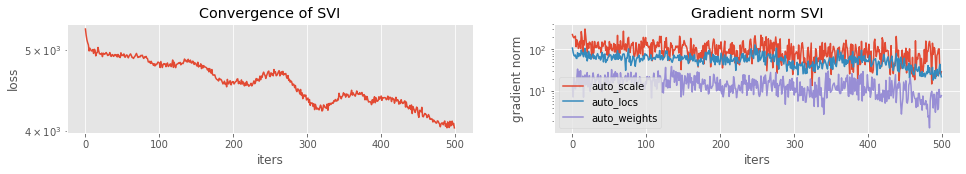

In [11]:
fig = pyplot.figure(figsize=(16, 2))
ax1 = fig.add_subplot(121, xlabel="iters", ylabel="loss",
                      yscale="log", title="Convergence of SVI")
ax1.plot(losses)
ax2 = fig.add_subplot(122, xlabel="iters", ylabel="gradient norm",
                      yscale="log", title="Gradient norm SVI")
for name, grad_norms in gradient_norms.items():
    ax2.plot(grad_norms, label=name)
ax2.legend()
fig.show()

In [12]:
def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    """Plot 2D GMMs"""
    fig = pyplot.figure()
    x = data[:, 0]
    y = data[:, 1]
    pyplot.scatter(x, y, 24, c=colors)

    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        pyplot.scatter(x, y, 99, c='red')

    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            try:
                cov = (torch.eye(d) * sigmas[sig_ix]).detach().numpy()
            except TypeError:
                cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

In [13]:
# Get MAP Estimates
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

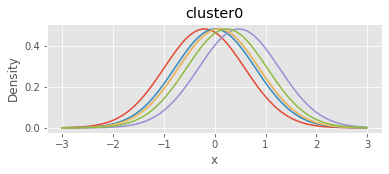

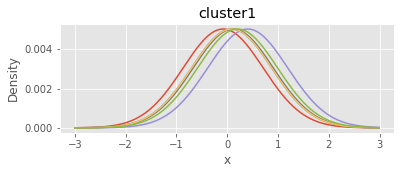

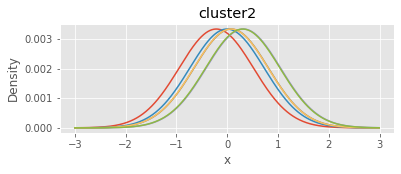

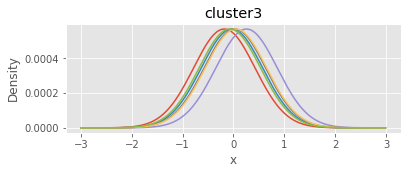

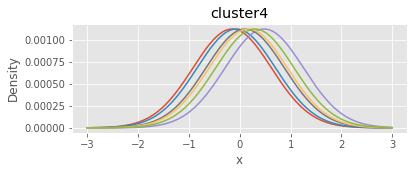

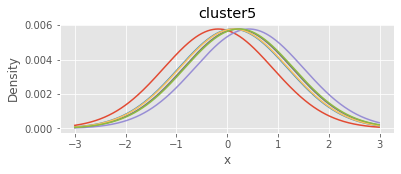

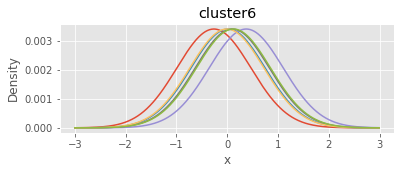

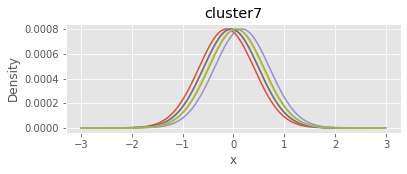

In [23]:
# Plot clusters, not components
for i in range(K):
    pyplot.figure(figsize=(6, 2))
    for j in range(d):
        X = np.arange(-3, 3, 0.01)
        pyplot.title('cluster'+str(i))
        pyplot.xlabel('x')
        pyplot.ylabel('Density')
        pyplot.plot(
            X, weights[i].item() *
            scipy.stats.norm.pdf(X, locs[i][j].item(), scale[i].item()))
pyplot.show()

In [15]:
# Plot PDI here

### Experiment 2: NUTS and Normal-LKJ Correlation Cholesky Prior

Problem:
* Clusters tend to converge together.
* Not fully probabilistic - Inverse Gamma prior for variance does not capture cross-covariances.

Alternative:
* For multivariate covariance matrix, one possible conjugate prior is the Inverse-Wishart distribution [Gelmen et al., Bayesian Data Analysis]
* However, the Inverse Wishart is not a suitable prior in practice. Firstly, This is because the positive-definite and symmetric constraints the probability of generating a valid sample by varying each element is almost zero; meaning it is difficult to sample from these objects. 
* Secondly, the Wishart distribution is heavy-tailed which causes problems for samplers. Heavy tails are obstructions to ergodicity which is a requirement for MCMC. When tails of the target distribution are heavy, the sampler drifts around in the tails and difficult to return back to heavy mass. Computational cost is a concern too.

Solution:
* MCMC for full posterior over components.
* Use the LKJ Correlation Cholesky Prior.
* Better tails and pairs with MCMC.
* Cholesky factors for computation.

Resources:
* https://docs.pymc.io/notebooks/LKJ.html
* https://dahtah.wordpress.com/2012/08/22/priors-of-convenience/
* https://docs.pymc.io/notebooks/LKJ.html
* https://www.researchgate.net/publication/335611122_An_introduction_to_data_analysis_using_the_PyMC3_probabilistic_programming_framework_A_case_study_with_Gaussian_Mixture_Modeling

Equation:

LKJ distribution provides prior on correlation matrix $C=Corr(x_{i}, x_{k})$.

By combining priors on $\sigma$ of each component, this induces a prior on the covariance matrix.

Inverting $\Sigma$ is numerically unstable and inefficient.

This inversion takes $\mathcal{O}(d^3)$.

Consider the cholesky decomposition s.t. $\Sigma= L L^T$.

$L$ is the lower-triangular matrix, which allows the computation of $(x-\mu)^T \Sigma^{-1} (x-\mu)$ using back substitution, which is more numerically stable.

\begin{align}
\pi &\sim Dir(\alpha) \\
\mu_k &\sim MVN(\mu_k, I)\\
\theta &\sim HalfCauchy(1) \\
L_\omega &\sim LKJCorrCholesky(\eta =2 ) \\
L_\Omega &\sim diag(\sqrt{\theta}) \times \omega
\end{align} 


In [16]:
def model(data):
    """
    LKJ Correlation Cholesky prior for full probabilistic covariance
    When using LKJ with NUTS, it is important to use a step_size such
    as 1e-4. If not, you are likely to experience LAPACK errors
    regarding positive-definiteness.
    """
    weights = pyro.sample('weights', dist.Dirichlet(0.5*torch.ones(K)))
    # hack: to_event(1) to fix tensor shapes
    theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(d)).to_event(1))
    eta = torch.ones(1)
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)

    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), 1*torch.eye(d)))

    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(
            mu[assignment], scale_tril=L_Omega), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'L_omega']))

In [17]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=100, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 150/150 [03:09,  1.27s/it, step size=2.62e-02, acc. prob=0.888]


In [43]:
# Compute posterior of Sigma from theta and L_Omega
Sigma_samples = []
for i in range(len(posterior_samples["theta"])):
    L_Omega = torch.mm(
        torch.diag(posterior_samples["theta"][i].sqrt()),
        posterior_samples["L_omega"][i])
    Sigma = torch.mm(L_Omega, L_Omega.t()).tolist()
    Sigma_samples.append(Sigma)
Sigma_samples = torch.tensor(Sigma_samples)

# Get bayes estimate of cov
Sigma_bayes_est = [[torch.mean(Sigma_samples[:, i, j]).item()
                    for j in range(d)] for i in range(d)]
cov = [Sigma_bayes_est for num_clusters in range(K)]
cov = torch.tensor(cov)

# Get bayes estimate of mean
mu = [[torch.mean(posterior_samples["locs"][:, i, j]).item()
       for j in range(d)] for i in range(K)]
mu = torch.tensor(mu)

# Get bayes estimate of pi
pi = [torch.mean(posterior_samples["weights"][:, i]).item()
      for i in range(K)]

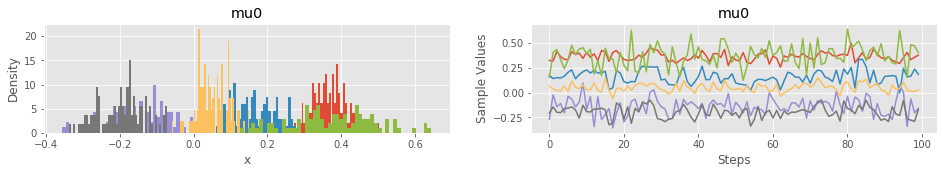

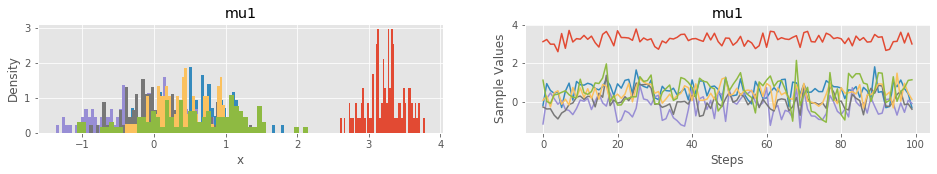

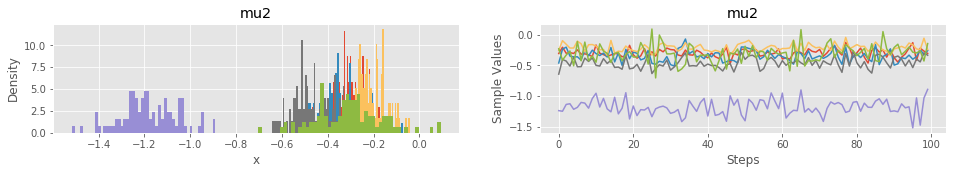

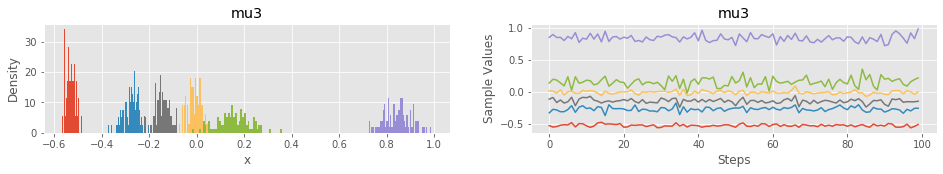

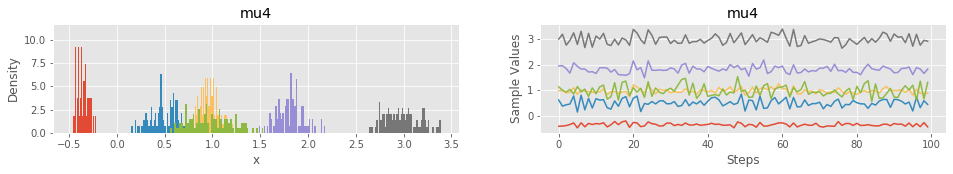

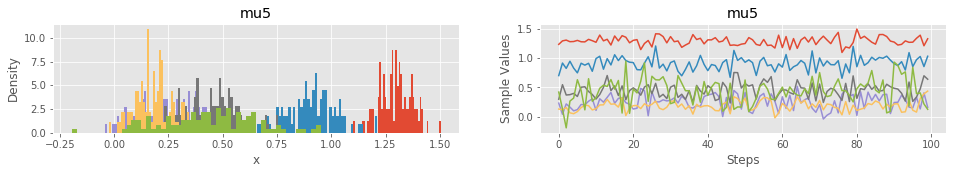

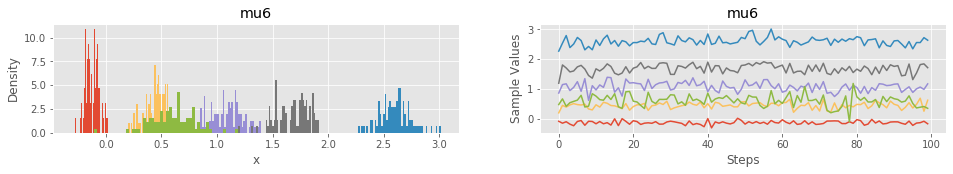

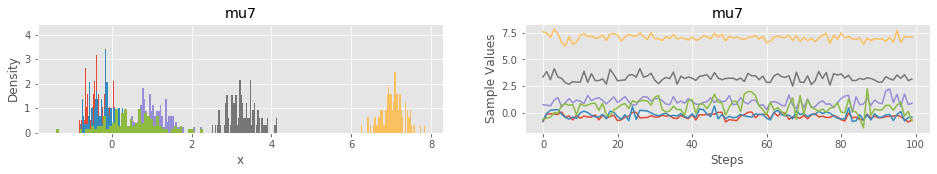

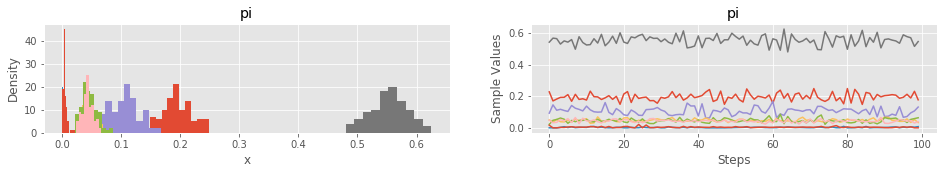

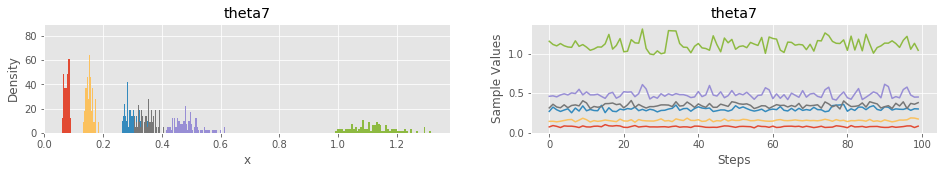

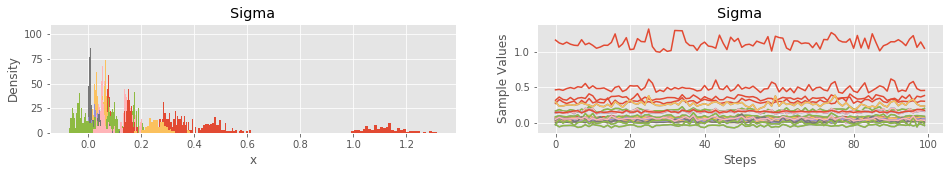

In [57]:
# Plot trace and full posterior of mu
for i in range(K):
    trace = posterior_samples["locs"][:, i, :]
    fig = pyplot.figure(figsize=(16, 2))
    for j in range(d):
        ax1 = fig.add_subplot(
            121, xlabel="x", ylabel="Density", title="mu"+str(i))
        ax1.hist(trace[:, j], 50, density=True)
        ax2 = fig.add_subplot(
            122, xlabel="Steps", ylabel="Sample Values", title="mu"+str(i))
        ax2.plot((trace[:, j]))
    fig.show()

# Plot posterior of pi
fig = pyplot.figure(figsize=(16, 2))
ax1 = fig.add_subplot(
    121, xlabel="x", ylabel="Density", title="pi")
ax2 = fig.add_subplot(
    122, xlabel="Steps", ylabel="Sample Values", title="pi")
for i in range(K):
    ax1.hist(posterior_samples["weights"][:, i])
    ax2.plot(posterior_samples["weights"][:, i])
fig.show()

# Plot posterior of theta
fig = pyplot.figure(figsize=(16, 2))
for j in range(d):
    ax1 = fig.add_subplot(
        121, xlabel="x", ylabel="Density", title="theta"+str(i))
    ax1.hist(posterior_samples["theta"][:, j], 50, density=True)
    ax2 = fig.add_subplot(
        122, xlabel="Steps", ylabel="Sample Values", title="theta"+str(i))
    ax2.plot(posterior_samples["theta"][:, j])
fig.show()

# Plot posterior of L_Omega

# Plot posterior of Sigma
fig = pyplot.figure(figsize=(16, 2))
ax1 = fig.add_subplot(
    121, xlabel="x", ylabel="Density", title="Sigma")
ax2 = fig.add_subplot(
    122, xlabel="Steps", ylabel="Sample Values", title="Sigma")
for i in range(d):
    for j in range(d):
        ax1.hist(Sigma_samples[:, i, j], 30, density=True)
        ax2.plot(Sigma_samples[:, i, j])
fig.show()

### Predicting memberships

In [62]:
from pyro.infer import Predictive

# Get latest predictions
predictive = Predictive(model, posterior_samples)
assignment = predictive.get_samples(data)["assignment"][-1, :]

([0.196057990193367,
  0.0028964076191186905,
  0.10648288577795029,
  0.5531464219093323,
  0.04751017689704895,
  0.04627286270260811,
  0.04296399652957916,
  0.004669267684221268],
 (array([ 86.,   1.,   0.,  69.,   0., 291.,  14.,   0.,  25.,  14.]),
  array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
  <a list of 10 Patch objects>),
 <Figure size 432x288 with 0 Axes>)

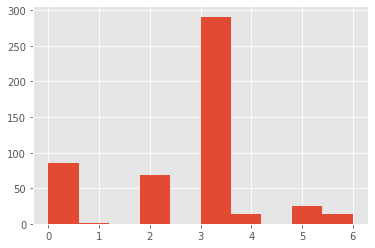

<Figure size 432x288 with 0 Axes>

In [67]:
pi, pyplot.hist(assignment), pyplot.figure()

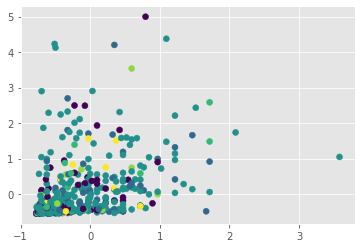

In [70]:
pyplot.figure()
pyplot.scatter(data[:, 0], data[:, 1], c=assignment)
pyplot.show()

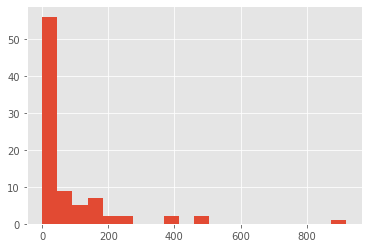

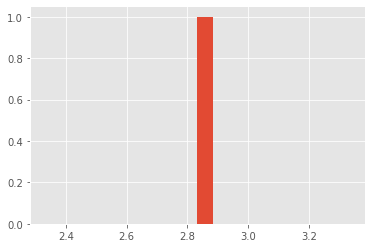

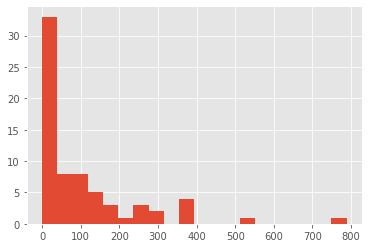

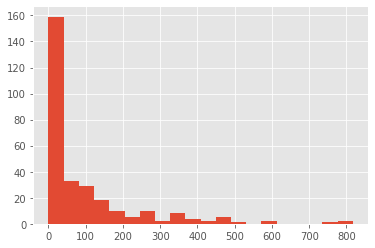

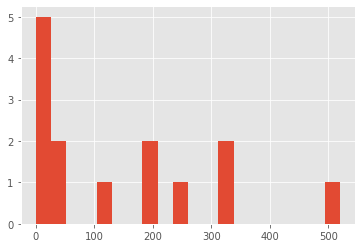

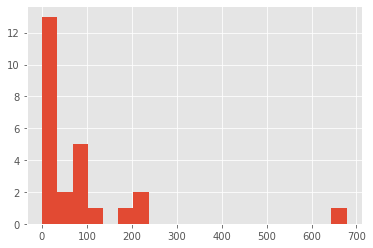

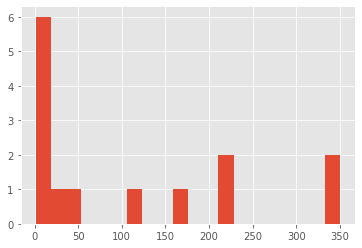

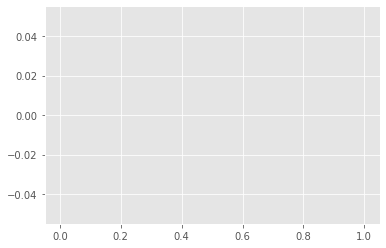

In [71]:
# Compare distributions of genres and date of all clusters
movies_metadata_sample['assignment'] = assignment.numpy()
for i in range(K):
    pyplot.figure()
    cluster = movies_metadata_sample[movies_metadata_sample['assignment'] == i]
    pyplot.hist(cluster['revenue_mil'], bins=20)

In [ ]:
movies_metadata_sample

### Posterior Predictive Checks

https://stats.stackexchange.com/questions/70855/generating-random-variables-from-a-mixture-of-normal-distributions?fbclid=IwAR1Gc44WXAPeyar7I5O-qCNqI0Qj8NjPIyXVyIJ3gACgEwNXlWmv_7pDNz0

https://docs.pymc.io/notebooks/posterior_predictive.html

For example, the discrepancy might use the latent variables to partition the observations and then measure a scalar discrepancy on each group (Mimno and Blei, 2011; Mimno et al., 2015).

Use realized discrepancies which is a function of both data and hidden variables $d(y, \theta)$

Taken from Ranganath, Blei, POP-PC

One discrepancy is the likelihood function of the GMM
\begin{equation}
l(\theta | x_1,\dots, x_n) = \log \prod_{i=1}^{n} \sum_{k=1}^{K} \pi_k N(x_i; \mu_k, \Sigma_k)
\end{equation}

Goal is to compute log-likelihood of each grouped data and find expectation over this

In [77]:
# Sample replicated data
data_rep = []
for i in range(N):
    cluster = pyro.sample('category', dist.Categorical(torch.tensor(pi)))
    idx = cluster.item()
    sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    data_rep.append(sample.tolist())
data_rep = torch.tensor(data_rep)

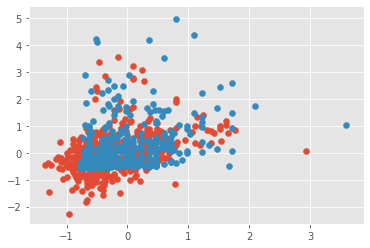

In [80]:
# Check visually
pyplot.figure()
pyplot.scatter(data_rep[:, 0], data_rep[:, 1])
pyplot.scatter(data[:, 0], data[:, 1])

In [81]:
# Compute discrepancy
d_obs = torch.mean(data)
d_rep = torch.mean(data_rep)
d_obs, d_rep

(tensor(0.1165), tensor(0.1174))

In [82]:
# Compute distance
distance = (d_rep - d_obs)**2

In [83]:
# Compute PPC
ppc = 1 * distance
ppc

tensor(9.2704e-07)

### Population Predictive Checks

"With grouped data, we can imagine a per-group check: “If my model is good (in a relevant way) then data drawn from the posterior predictive distribution of a group will look like data from the true population of that group.” The corresponding discrepancy is d(yj, zj, θ). Notice that using this discrepancy requires new local data from the population distribution of the jth group Fj. Per-group pop-pcs check how well new data in a group match replications from the posterior predictive distribution of that group." Ranganath, Blei 

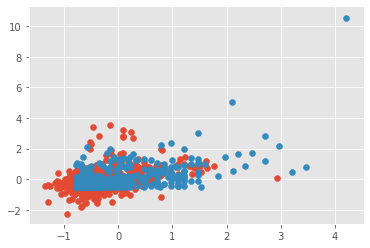

In [85]:
# Check visually
pyplot.figure()
pyplot.scatter(data_rep[:, 0], data_rep[:, 1])
pyplot.scatter(data_new[:, 0], data_new[:, 1])

In [86]:
# Compute discrepancy
d_rep = torch.mean(data_rep)
d_new = torch.mean(data_new)
d_rep, d_new

(tensor(0.1174), tensor(-0.0475))

In [87]:
# Compute distance
distance = (d_rep - d_new)**2

In [88]:
# Compute POP-PC
pop_pc = 1 * distance
pop_pc

tensor(0.0272)

In [96]:
# Compute new discrepancy, which is the log likelihood to take into account
# Observed
test_obs = 0
for i in range(N):
    for j in range(K):
        test_obs += np.log(pi[j]) \
            + dist.MultivariateNormal(mu[j], cov[j]).log_prob(data[i])

In [97]:
# Rep
test_rep = 0
for i in range(N):
    for j in range(K):
        test_rep += np.log(pi[j]) \
            + dist.MultivariateNormal(mu[j], cov[j]).log_prob(data_rep[i])

In [98]:
# New
test_new = 0
for i in range(N):
    for j in range(K):
        test_new += np.log(pi[j]) \
            + dist.MultivariateNormal(mu[j], cov[j]).log_prob(data_new[i])

In [99]:
test_obs, test_rep, test_new

(tensor(-220478.8750), tensor(-222317.2500), tensor(-218473.5938))

In [100]:
(test_obs - test_rep)**2

tensor(3379622.7500)